# Tutorial for R Users

In this introductory tutorial, we go through the different steps of a CausalEGM workflow.

Python users can use **RcausalEGM**, a R libary for implementing CausalEGM.

First of all, you need to install CausalEGM, please refer to the [install page](https://causalegm.readthedocs.io/en/latest/installation.html) to make sure **RcausalEGM** R package is installed.


<div class="alert alert-warning">

**Note**

`RcausalEGM` R package was developed with `reticulate` package, which enables building R APIs based on Python APIs. Installing `RcausalEGM` will automatically install the dependent `reticulate` package.

</div>

Run the `py_config()` after loading `reticulate` to get the Python configuration information, detailed configuration can be found in reticulate [website](https://rstudio.github.io/reticulate/articles/versions.html).

In [1]:
#library(reticulate)
#py_config()

In [2]:
library(RcausalEGM)

## Binary treatment 

We first give a step-by-step tutorial for implementing CausalEGM under binary treatment settings.

### Data generation


Let's first generate a simulation dataset with binary treatment. Users could also define their own data, which include treatment (`x`), outcome (`y`), and covariates (`v`).

In [3]:
n <- 500
p <- 20
v <- matrix(rnorm(n * p), n, p)
x <- rbinom(n, 1, 0.3 + 0.2 * (v[, 1] > 0))
y <- pmax(v[, 1], 0) * x + v[, 2] + pmin(v[, 3], 0) + rnorm(n)

Let's take a look at the simulation data.

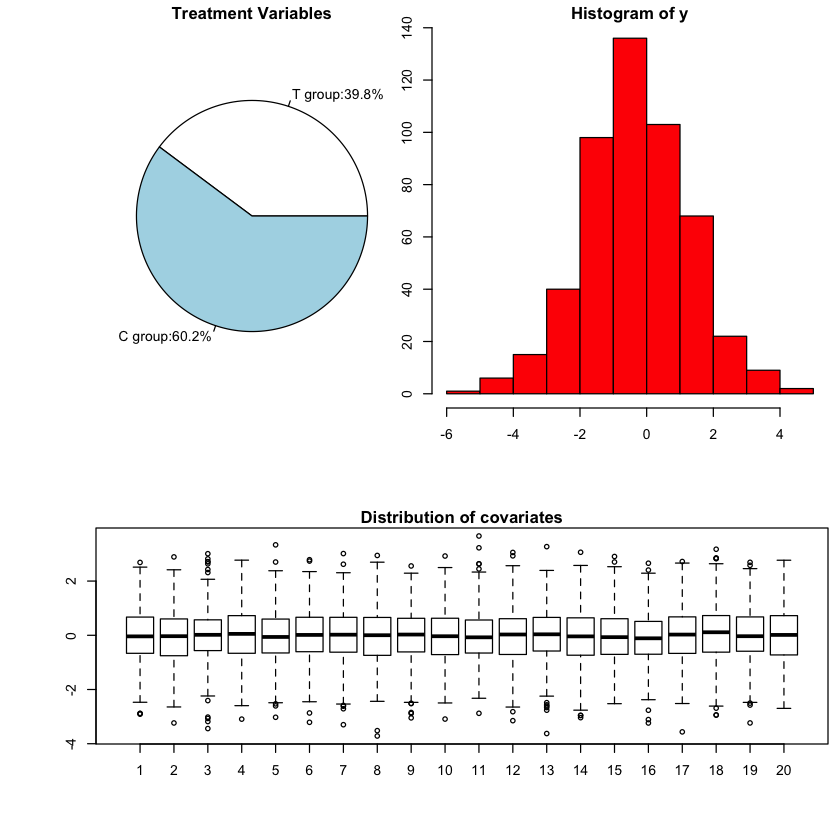

In [4]:
par(cex=0.7, mai=c(0.1,0.1,0.2,0.1))
par(fig=c(0.1,0.5,0.5,1.0))
slices <- c(sum(x==1), sum(x==0))
lbls <- c(paste("T group:",round(sum(x==1)*100/length(x), 2), "%", sep=""), paste("C group:",round(sum(x==0)*100/length(x), 2), "%", sep=""))
pie(slices, labels = lbls, main="Treatment Variables")
par(fig=c(0.5,1,0.5,1), new=TRUE)
hist(y, breaks=12, col="red",xlab="y values")
par(fig=c(0.1,1.0,0.1,0.4), new=TRUE)
boxplot(v, main="Distribution of covariates", xlab="Covariate index", ylab="Values")

### Model training

Start training a CausalEGM model. Users can refer to the core API "causalegm" by `help(causalegm)` for detailed usage.

Note that the parameters for treatment (`x`), outcome (`y`), and covariates (`v`) are required. Besides, users can also specify the `z_dims` as a integer list with four elements denoting the latent dimensions.

<div class="alert alert-info">
<b>Important</b>

 1)  **causalegm** is the main R API for the *Rcausalegm* R package. 
   
 2)  **causalegm** API includes CausalEGM model initilization and model training.
    
 3)  The parameters for **causalegm** are consistent with the Python APIs.

</div>

In [5]:
#help(causalegm)
model <- causalegm(x=x,y=y,v=v,
                   z_dims = c(3,3,6,6),
                   n_iter=200)

### Treatment Effect Estimation

After the above model training, users can find the .txt format of individual treatment effect (ITE) estimates in the "output_dir" directory (parameter in "causalegm") if `save_res` is set to `TRUE`.

Alternatively, several keys estimates, including average treatment effect and individual treatment effect can be directly obtained from the trained model.

[1] "The average treatment effect (ATE) is -0.051"

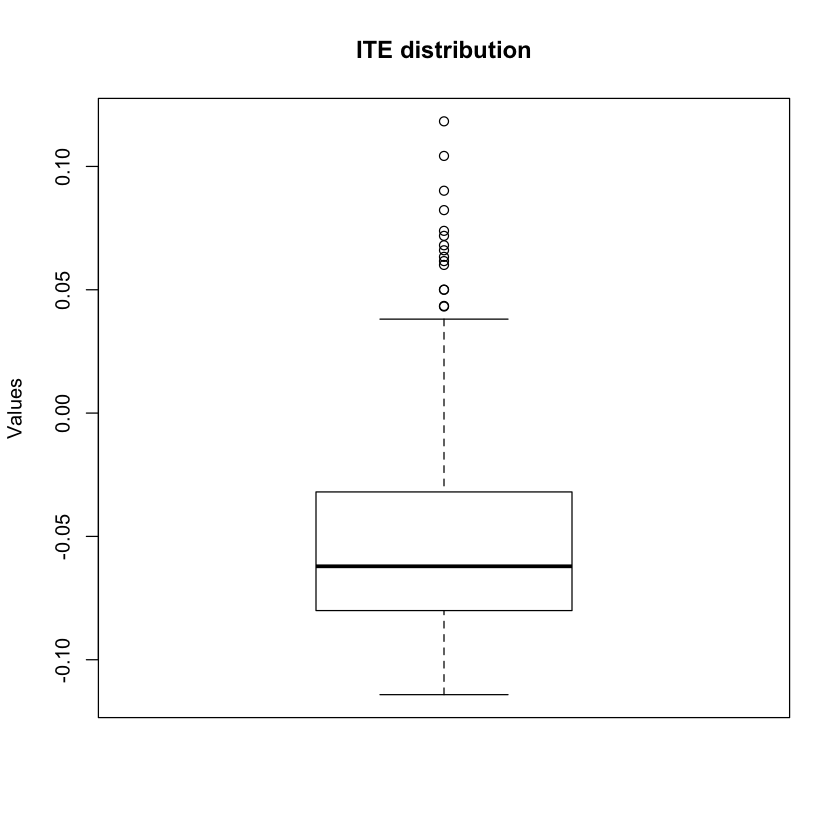

In [6]:
ATE <- model$ATE
paste("The average treatment effect (ATE) is", round(ATE, 3))
ITE <- model$best_causal_pre
boxplot(ITE, main="ITE distribution", ylab="Values")

### Predicting Counterfactual Outcome

Besides ATE and ITE estimation, we also provide APIs for predicting the counterfactual outcome directly.

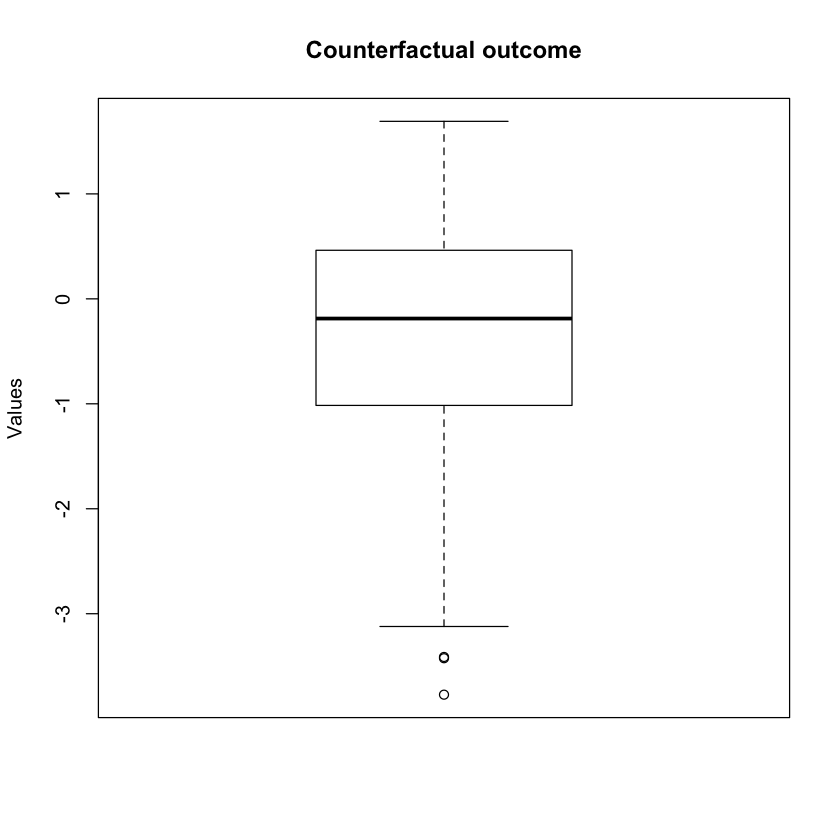

In [7]:
x_cf <- 1-x
y_cf <- get_est(model, v, x_cf)
boxplot(y_cf, main="Counterfactual outcome", ylab="Values")

### Estimating Conditional Average Treatment Effect (CATE)

We demonstrate how to estimate CATE by an external data after training the model.

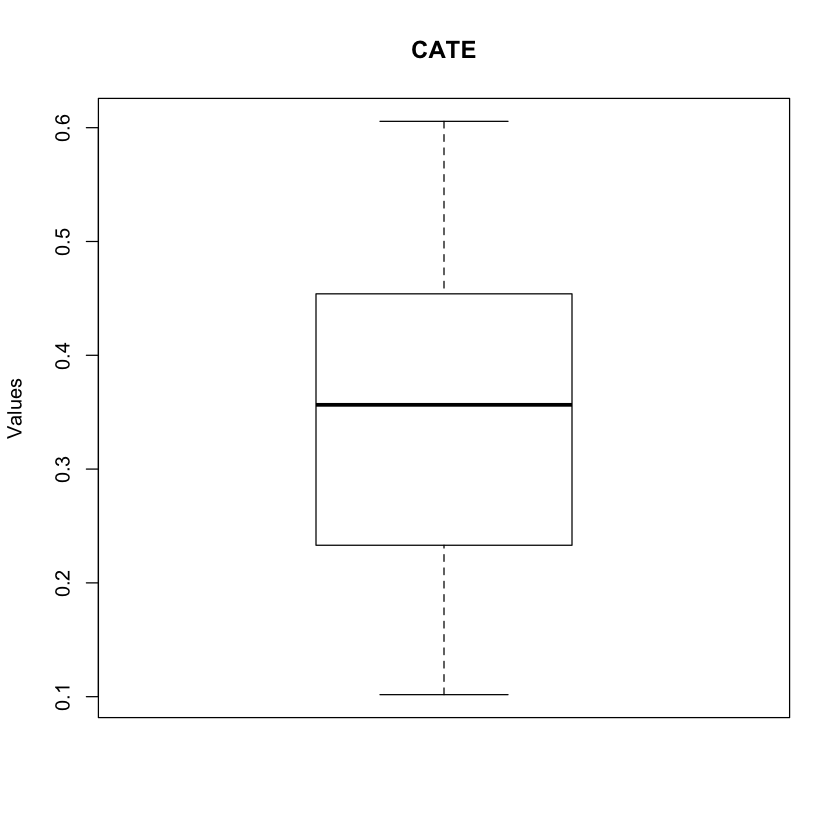

In [8]:
n_test <- 100
v_test <- matrix(rnorm(n_test * p), n_test, p)
CATE <- get_est(model, v_test)
boxplot(CATE, main="CATE", ylab="Values")

## Continuous treatment

We first give a step-by-step tutorial for implementing CausalEGM under continuous treatment settings. We use the Hirano and Imbens simulation dataset for an example.

In [9]:
n <- 20000
p <- 200
v <- matrix(rexp(n * p), n, p)
rate <- v[,1] + v[,2]
scale = 1/rate
x = rexp(n=n, rate=rate)
y = rnorm(n=n, mean = x + (v[,1] + v[,3])*exp(-x * (v[,1] + v[,3])), sd=1)

Let's take a look at the simulation data.

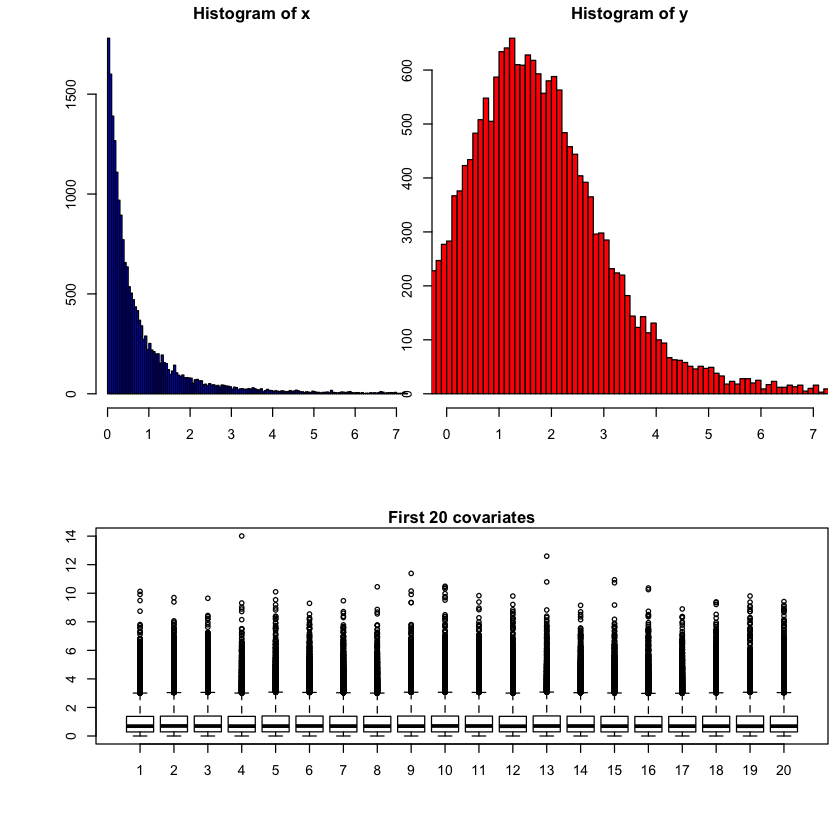

In [10]:
par(cex=0.7, mai=c(0.1,0.1,0.2,0.1))
par(fig=c(0.1,0.5,0.5,1.0))
hist(x, breaks="FD", xlim=c(0,7), col="blue",xlab="x values")
par(fig=c(0.5,1,0.5,1), new=TRUE)
hist(y, breaks="FD", xlim=c(0,7), col="red",xlab="y values")
par(fig=c(0.1,1.0,0.1,0.4), new=TRUE)
boxplot(v[,1:20],main="First 20 covariates", xlab="Covariate index", ylab="v values")


### Model training

Start training a CausalEGM model. Users can refer to the core API "causalegm" by help(causalegm) for detailed usage.

Note that the parameters for x, y, v  are required. Besides, users can also specify the z_dims as a integer list with four elements.

(x_min, x_max) is the interval of treatment on which we evaluate the causal effect.

The key binary_treatment is set to be FALSE as we are dealing with continuous treatment.

In [11]:
#help(causalegm)
model <- causalegm(x=x,y=y,v=v,
                   z_dims = c(1,1,1,7),
                   n_iter=20000, 
                   binary_treatment = FALSE, 
                   use_v_gan = FALSE, 
                   x_min=0, 
                   x_max=3)

### Treatment Effect Estimation

The average causal effect evaluated at the 200 uniform points in the interval (x_min, x_max) can be directly obtained from the trained model.

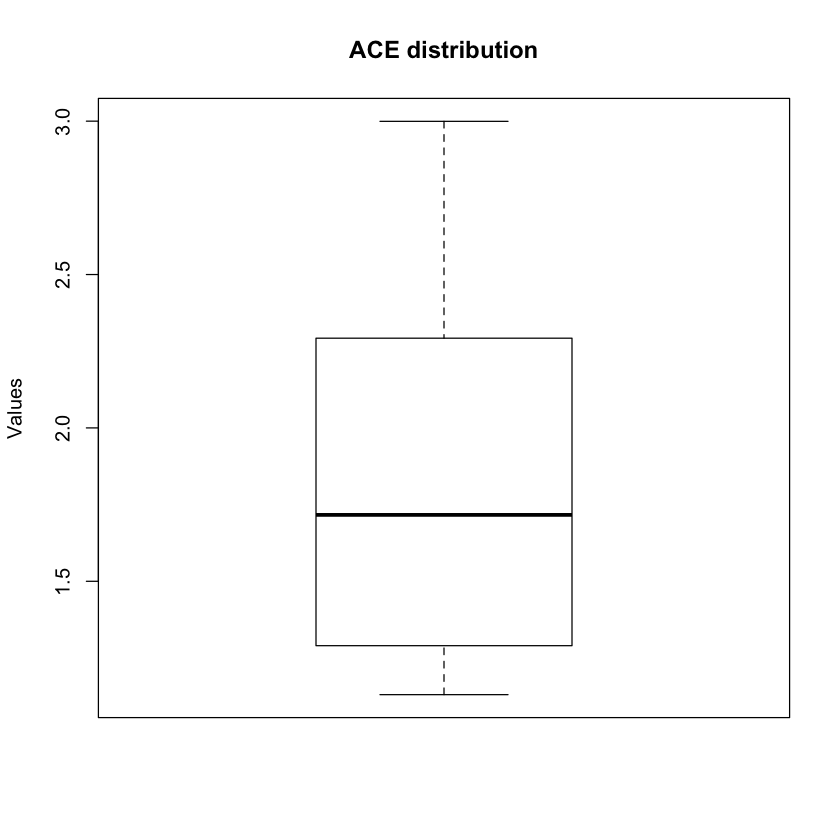

In [12]:
ACE <- model$best_causal_pre
boxplot(ACE, main="ACE distribution", ylab="Values")

### Plot of the average dose-response function (ADRF)

We now compare plot of the true ADRF and the ADRF estimated by our model.

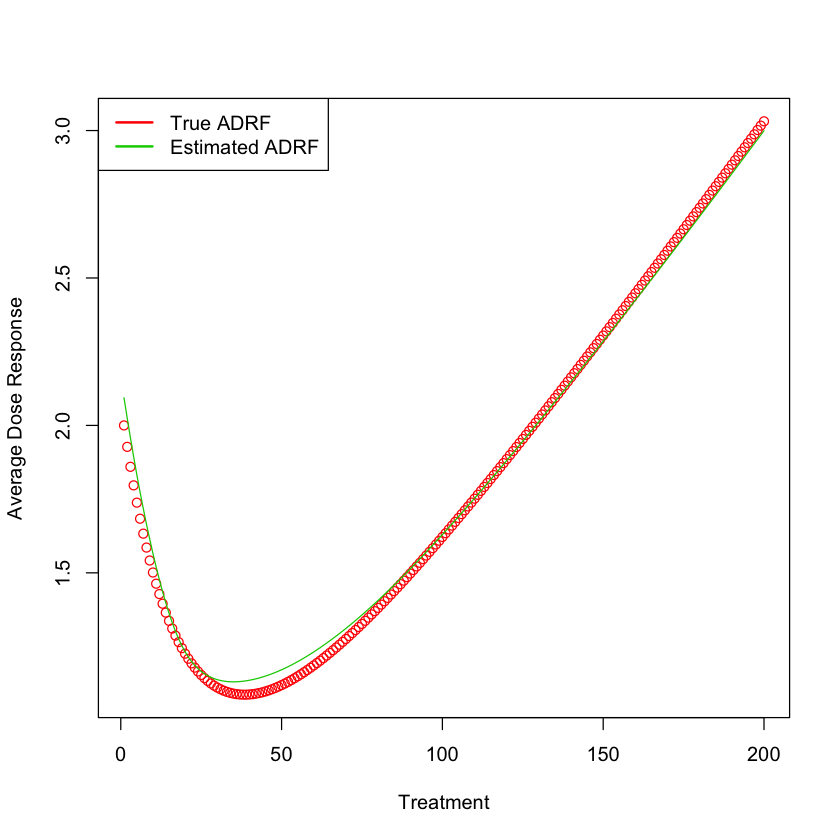

In [13]:
grid_val = seq(0, 3, length.out=200)
true_effect = grid_val + 2 * (1+grid_val)**(-3)
plot(true_effect, col=2, xlab="Treatment", ylab="Average Dose Response")
lines(ACE, col=3)
legend(x = "topleft", 
       legend = c("True ADRF", "Estimated ADRF"),  
       lty = c(1, 1), 
       col = c(2, 3),        
       lwd = 2)  

In [14]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.6/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] RcausalEGM_0.3.3

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.7      uuid_1.0-3      lattice_0.20-38 here_1.0.1     
 [5] rlang_1.1.0     fastmap_1.1.0   fansi_0.5.0     tools_3.6.3    
 [9] grid_3.6.3      png_0.1-7       utf8_1.2.2      cli_3.3.0      
[13] withr_2.4.3     htmltools_0.5.2 ellipsis_0.3.2  rprojroot_2.0.2
[17] digest_0.6.29   lifecycle_1.0.1 crayon_1.4.2    Matrix_1.3-4   
[21] IRdisplay_1.1   repr_1.1.6      base64enc_0.1-3 vctrs_0.4.1    
[25] IRkernel_1.3.2  eval